# Поиск изображения по текстовому запросу

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Импорты

In [1]:
import os
import torch
import transformers
import time

import pandas as pd
import numpy as np
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.dummy import DummyRegressor
from sentence_transformers import SentenceTransformer, util

In [2]:
DATA_PATH = './'

PATH_TRAIN_IMG = os.path.join(DATA_PATH, 'train_images/')
PATH_TEST_IMG = os.path.join(DATA_PATH, 'test_images/')
PLACEHOLDER_IMG = os.path.join(DATA_PATH, 'placeholder-image.jpg')

Плейсхолдер в случае непрохождения запросом цензуры 

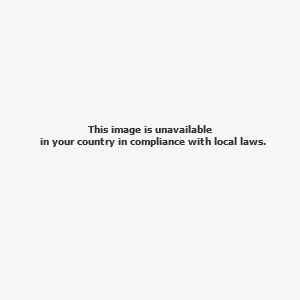

In [3]:
# Отлключаем ворнинг о присвоении по цепочке
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
# Определяем, можем ли мы проводить вычисления на GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
f'Using device: {device}'

'Using device: cuda'

## Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

### `train_dataset.csv`

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

In [5]:
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [7]:
df_train.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

Данный датафрейм содержит 5822 записи и содержит следующие признаки:
* `image` - имя файла изображения,
* `query_id` - идентификатор описания изображения,
* `query_text` - текст описания изображения.

### `train_images`

В папке `train_images` содержатся изображения для тренировки модели.

In [8]:
f'Количество изображений в папке train_images: {len(os.listdir(PATH_TRAIN_IMG))}'

'Количество изображений в папке train_images: 1000'

### `CrowdAnnotations.tsv`

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

In [9]:
df_crowd = pd.read_csv(os.path.join(DATA_PATH, 'CrowdAnnotations.tsv'), sep='\t', names=['image', 'query_id', 'crowd_score', 'crowd_positive', 'crowd_negative'])

In [10]:
df_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   crowd_score     47830 non-null  float64
 3   crowd_positive  47830 non-null  int64  
 4   crowd_negative  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [11]:
df_crowd.head()

image                     query_id  crowd_score  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0   

   crowd_positive  crowd_negative  
0               3               0  
1               0               3  
2               0               3  
3               0               3  
4               0               3

Данный датафрейм содержит 47830 записи и содержит следующие признаки:
* `image` - имя файла изображения,
* `query_id` - идентификатор описания изображения,
* `crowd_score` - доля людей, считающих, что описание соответствует изображению, целевой признак,
* `crowd_positive` - количество человек, считающих, что описание соответствует изображению,
* `crowd_negative` - количество человек, считающих, что описание не соответствует изображению.

### `ExpertAnnotations.tsv`

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

In [12]:
df_expert = pd.read_csv(os.path.join(DATA_PATH, 'ExpertAnnotations.tsv'), sep='\t', names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])

In [13]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [14]:
df_expert.head()

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

Данный датафрейм содержит 5822 записи и содержит следующие признаки:
* `image` - имя файла изображения,
* `query_id` - идентификатор описания изображения,
* `expert_1` - оценка соответствия между описанием и изображением от эксперта №1, 
* `expert_2` - оценка соответствия между описанием и изображением от эксперта №2,
* `expert_3` - оценка соответствия между описанием и изображением от эксперта №3.

### `test_queries.csv`

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

In [15]:
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'), sep='|').drop('Unnamed: 0', axis=1)

In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [17]:
df_test.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

Данный датафрейм содержит 500 записей и содержит следующие признаки:
* `query_id` - идентификатор описания изображения,
* `query_text` - текст описания изображения,
* `image` - имя файла изображения.

### `test_images`

В папке `test_images` содержатся изображения для тестирования модели.

In [18]:
f'Количество изображений в папке train_images: {len(os.listdir(PATH_TEST_IMG))}'

'Количество изображений в папке train_images: 100'

## Исследовательский анализ данных

### Введение

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

### Уникальность комбинации `image` и `query_id`

Данные у нас раскиданы по трём датасетам. Комбинация `image` и `query_id` должны быть уникальными. Проверим это.

In [19]:
def check_unique(dataframe):
    # Проверка dataframe на уникальность комбинации image и query_id
    group = dataframe.groupby(['image', 'query_id']).size().reset_index().rename(columns={0:'count'})
    return group

In [20]:
group_train = check_unique(df_train)
display(group_train['count'].value_counts())

count
1    5822
Name: count, dtype: int64

In [21]:
group_crowd = check_unique(df_crowd)
display(group_crowd['count'].value_counts())

count
1    47830
Name: count, dtype: int64

In [22]:
group_expert = check_unique(df_expert)
display(group_expert['count'].value_counts())

count
1    5822
Name: count, dtype: int64

### Проверка на дубликаты 

Проверим, что в наших датасетах нет полных дубликатов.

In [23]:
df_train.duplicated().sum()

0

In [24]:
df_crowd.duplicated().sum()

0

In [25]:
df_expert.duplicated().sum()

0

### Целевой признак в `df_crowd`

В `df_crowd` целевым признаком является `crowd_score` (доля людей, считающих, что описание соответствует изображению). Посмотрим на распределение данного значения в датасете.

In [26]:
crowd_target = df_crowd['crowd_score'].value_counts().sort_index()
crowd_target

crowd_score
0.000000    41970
0.166667        3
0.200000       22
0.250000       96
0.333333     3000
0.400000        8
0.500000       27
0.600000        8
0.666667     1360
0.750000        9
0.800000        4
1.000000     1323
Name: count, dtype: int64

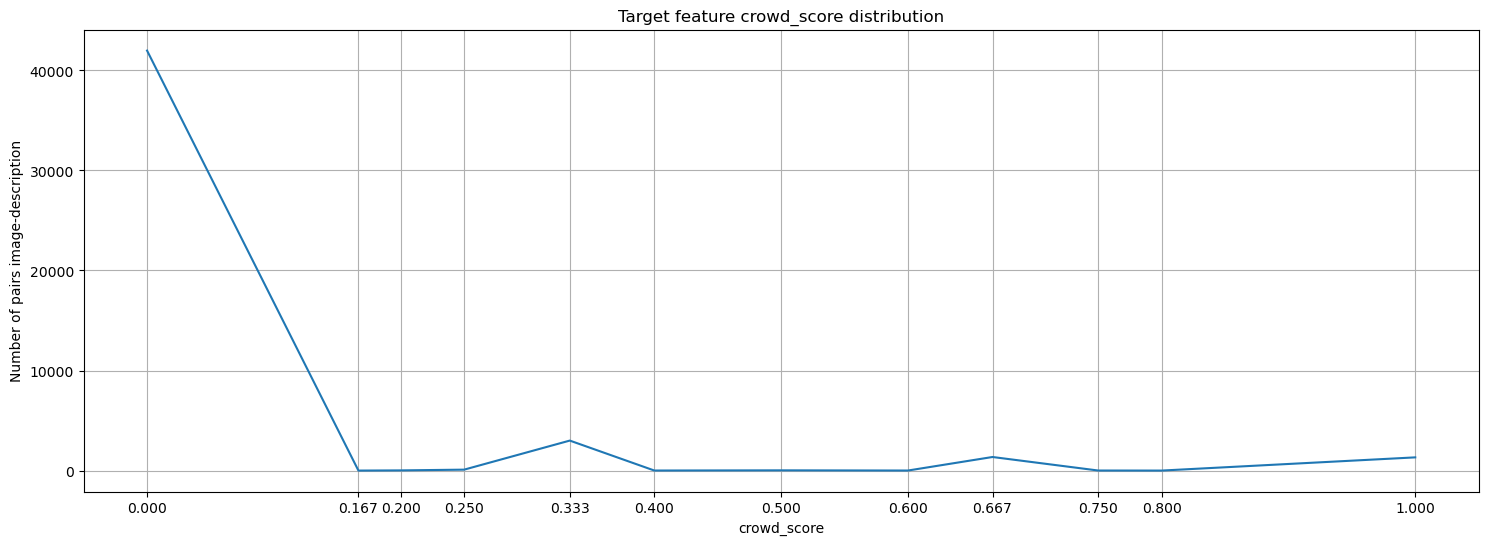

In [27]:
# построим график распределения целевого признака в датасете
x = list(crowd_target.index)
y = list(crowd_target.array)

plt.figure(figsize=(18,6))
plt.title('Target feature crowd_score distribution')
plt.grid(visible=True)
plt.xticks(x)
plt.xlabel('crowd_score')
plt.ylabel('Number of pairs image-description')
plt.plot(x, y)
plt.show()

Наглядно видно, что датасет `df_crowd` имеет очень сильный перекос в сторону `crowd_score`, равному 0. Датасет содержит почти 42 тысячи пар изображение-описание, которые не подходят друг-другу.

### Целевой признак в `df_expert`

Датасет `df_expert` устроент иначе, чем `df_crowd`. В данном датасете нет подготовленной единой оценки. В данном датасете имеется оценки трёх экспертов по шкале от 1 (описание полностью не подходит) до 4 (описание полностью подходит). Сформируем новый признак: найдём среднее значение оценки и нормализуем до диапазона от 0 до 1.

In [28]:
df_expert['expert_score'] = (((df_expert['expert_1'] + df_expert['expert_2'] + df_expert['expert_3']) / 3) - 1) / 3

In [29]:
df_expert.head()

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  expert_score  
0         1      0.000000  
1         2      0.111111  
2         2      0.111111  
3         2      0.222222  
4         2      0.111111

Теперь оценим распределение получившегося признака

In [30]:
expert_target = df_expert['expert_score'].value_counts().sort_index()
expert_target

expert_score
0.000000    2350
0.111111     965
0.222222     689
0.333333     678
0.444444     324
0.555556     193
0.666667     241
0.777778      75
0.888889      60
1.000000     247
Name: count, dtype: int64

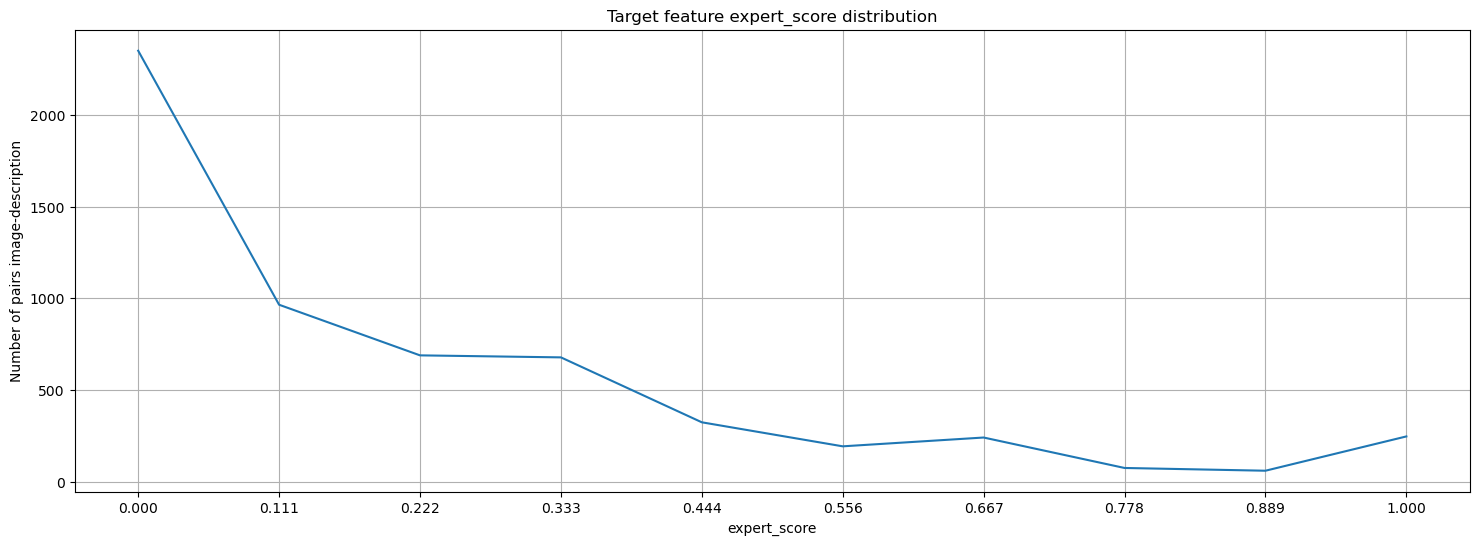

In [31]:
# построим график распределения целевого признака в датасете
x = list(expert_target.index)
y = list(expert_target.array)

plt.figure(figsize=(18,6))
plt.title('Target feature expert_score distribution')
plt.grid(visible=True)
plt.xticks(x)
plt.xlabel('expert_score')
plt.ylabel('Number of pairs image-description')
plt.plot(x, y)
plt.show()

Как мы можем видеть на графике, данный датасет так же обладает значительным смещением в сторону негативного класса целевого признака.

### Объединение датасетов 

В дальнейшем мы будем использовать данные о оценках только из экспертного датасета из-за их высокого качества.

Объеденим датасеты `df_expert` и `df_train`.

In [32]:
df_score = pd.merge(df_expert, df_train, how='left', on=['image', 'query_id'])

In [33]:
df_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         5822 non-null   object 
 1   query_id      5822 non-null   object 
 2   expert_1      5822 non-null   int64  
 3   expert_2      5822 non-null   int64  
 4   expert_3      5822 non-null   int64  
 5   expert_score  5822 non-null   float64
 6   query_text    5822 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 318.5+ KB


In [34]:
df_score.head()

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  expert_score                                         query_text  
0         1      0.000000  A young child is wearing blue goggles and sitt...  
1         2      0.111111  A girl wearing a yellow shirt and sunglasses s...  
2         2      0.111111    A man sleeps under a blanket on a city street .  
3         2      0.222222  A woman plays with long red ribbons in an empt...  
4         2      0.111111         Chinese market street in the winter time .

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [36]:
# Список слов и фраз для фильтрации
keywords = [
    'baby', 'child', 'toddler', 'kid', 'infant', 'newborn', 'boy', 'girl', 'teenager', 'teen',
    'juvenile', 'youngster', 'preschooler', 'schoolboy', 'schoolgirl', 'minor', 'playing', 'toy',
    'school', 'kindergarten', 'daycare', 'nursery', 'stroller', 'diaper', 'pacifier',
    'playground', 'cartoon', 'toy', 'doll', 'stuffed animal', 'crib', 'highchair', 'onesie',
    'parent', 'mom', 'dad', 'mother', 'father', 'nanny', 'babysitter', 'guardian'
]

In [37]:
# Функция для проверки наличия ключевых слов в описании
def contains_keywords(row, keywords):
    query_text = row['query_text']
    if any(keyword in query_text.lower() for keyword in keywords):
        image_name = row['query_id'][:-2]
        return image_name
    else:
        return np.nan

In [38]:
# Получаем Series с изображениями, которые не проходят проверку
images_to_remove = df_score.apply(contains_keywords, axis=1, args=(keywords,)).dropna(ignore_index=True)
images_to_remove

0       2549968784_39bfbe44f9.jpg
1       2718495608_d8533e3ac5.jpg
2       3545652636_0746537307.jpg
3       1714316707_8bbaa2a2ba.jpg
4       2140182410_8e2a06fbda.jpg
                  ...            
1766    1317292658_ba29330a0b.jpg
1767     533979933_a95b03323b.jpg
1768    3079787482_0757e9d167.jpg
1769    3108197858_441ff38565.jpg
1770    3482062809_3b694322c4.jpg
Length: 1771, dtype: object

In [39]:
# Переводим Series в сет
images_to_remove_set = set(images_to_remove)

In [40]:
# Количество изображений, которые не проходят проверку
len(images_to_remove_set)

328

In [41]:
# Удаляем изображения из датасета df_score
df_filtered = df_score[~df_score['image'].isin(images_to_remove_set)].reset_index(drop=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3866 entries, 0 to 3865
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         3866 non-null   object 
 1   query_id      3866 non-null   object 
 2   expert_1      3866 non-null   int64  
 3   expert_2      3866 non-null   int64  
 4   expert_3      3866 non-null   int64  
 5   expert_score  3866 non-null   float64
 6   query_text    3866 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 211.6+ KB


В результате фильтрации датасет уменьшился до 3866 строк.

Посмотрим на распределение признака `expert_score` в датасете после фильтрации.

In [42]:
filtered_target = df_filtered['expert_score'].value_counts().sort_index()
filtered_target

expert_score
0.000000    1464
0.111111     626
0.222222     441
0.333333     457
0.444444     234
0.555556     156
0.666667     188
0.777778      58
0.888889      47
1.000000     195
Name: count, dtype: int64

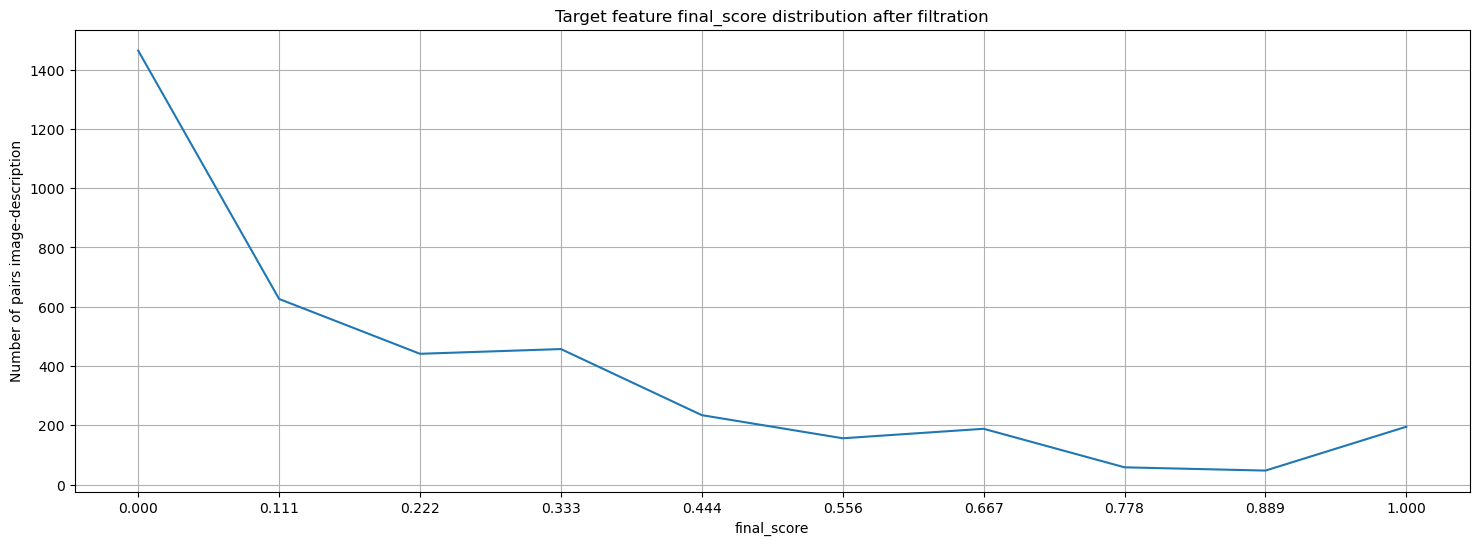

In [43]:
# Визуализируем распределение целевого признака по датасету
x = list(filtered_target.index)
y = list(filtered_target.array)

plt.figure(figsize=(18,6))
plt.title('Target feature final_score distribution after filtration')
plt.grid(visible=True)
plt.xticks(x)
plt.xlabel('final_score')
plt.ylabel('Number of pairs image-description')
plt.plot(x, y)
plt.show()

После фильтрации распределение целевого признака в датасете не сильно изменилось.

## Векторизация изображений

### Введение

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

### Векторизация изображений 

Для векторизации изображений мы будем использовать модель ResNet50 из библиотеки Torch.

In [44]:
# Создадим кастомный датасет для загрузки изображений
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.img_names[idx]

In [45]:
# Трансформации, которые будем использовать для предобработки изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [46]:
# Загрузка предобученной модели ResNet50
model_resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)
model_resnet50 = torch.nn.Sequential(*list(model_resnet50.children())[:-1])

model_resnet50 = model_resnet50.to(device)
model_resnet50.eval();

In [47]:
# Загружаем изображения
dataset = ImageDataset(PATH_TRAIN_IMG, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [48]:
# Вычисление векторных представлений

image_vectors = {}
with torch.no_grad():
    for images, img_names in tqdm(dataloader, desc="Processing Images"):
        images = images.to(device)
        vectors = model_resnet50(images)
        vectors = vectors.view(vectors.size(0), -1)
        vectors = vectors.cpu().numpy()
        for i, img_name in enumerate(img_names):
            image_vectors[img_name] = vectors[i]

Processing Images: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]


### Проверка полученных векторов

In [ ]:
# Словарь image_vectors содержит векторы для каждого изображения
# Вывод удалён для сокращения объема тетради
display(f'Длина словаря image_vectors: {len(image_vectors)} записей')
image_vectors

In [50]:
# Проверяем доступ по ключу
image_vectors.get('1056338697_4f7d7ce270.jpg')

array([0.5487753 , 0.07379454, 0.10731208, ..., 0.147832  , 0.        ,
       0.00251   ], dtype=float32)

### Преобразование полученных векторов

In [51]:
# Преобразуем словарь в датафрейм
df_image_vectors = pd.Series(image_vectors).to_frame()
df_image_vectors['image'] = df_image_vectors.index
df_image_vectors = df_image_vectors.reset_index(drop=True)
df_image_vectors = df_image_vectors.rename({0:'image_vector'}, axis=1)
df_image_vectors

image_vector  \
0    [0.5487753, 0.073794544, 0.10731208, 1.0176281...   
1    [0.0, 0.0, 0.018390251, 0.10857771, 0.0, 0.0, ...   
2    [0.18755932, 0.0, 0.461141, 0.05594308, 0.0, 0...   
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0034367247, 0.0014...   
4    [0.09129819, 0.005631413, 0.030553972, 3.10775...   
..                                                 ...   
995  [0.0, 0.0, 0.0, 0.0, 0.0, 0.02632162, 0.0, 0.0...   
996  [0.2678566, 0.013090897, 0.06599994, 0.0, 0.13...   
997  [0.9825774, 0.0, 1.2096063, 0.020180916, 0.100...   
998  [0.10550384, 0.0, 0.2022044, 0.3404192, 0.3050...   
999  [0.74396664, 0.013107392, 0.004384259, 0.0, 0....   

                         image  
0    1056338697_4f7d7ce270.jpg  
1     106490881_5a2dd9b7bd.jpg  
2    1082379191_ec1e53f996.jpg  
3    1084040636_97d9633581.jpg  
4    1096395242_fc69f0ae5a.jpg  
..                         ...  
995   929679367_ff8c7df2ee.jpg  
996    96420612_feb18fc6c6.jpg  
997   968081289_cdba83ce2e.jpg  
998   979383193_0a542a059d.jpg  
999   997722733_0cb5439472.jpg  

[1000 rows x 2 columns]

In [52]:
df_image_vectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_vector  1000 non-null   object
 1   image         1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [53]:
# Проверяем, что можем извлечь именно массив numpy
sample_vector = df_image_vectors.iloc[0].image_vector
type(sample_vector)

numpy.ndarray

In [ ]:
# Проверяем, что массив извлекается полностью
# Вывод удалён для сокращения объема тетради
np.set_printoptions(threshold=10000)
sample_vector

In [55]:
# Возвращаем пороговое значение по-умолчанию
np.set_printoptions(threshold=1000)

In [56]:
df_image_vectors.iloc[0].image_vector

array([0.5487753 , 0.07379454, 0.10731208, ..., 0.147832  , 0.        ,
       0.00251   ], dtype=float32)

## Векторизация текстов

### Введение

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

### Векторизация текстов

Для векторизации будем использовать модель 'bert-base-uncased'.

Отфильтруем датафрейм и оставим только уникальные значения query_id

In [57]:
# Проверим, сколько уникальных query_id имеется в датафрейме
df_filtered['query_id'].unique().shape

(932,)

In [58]:
df_unique_query = df_filtered.drop_duplicates(subset=['query_id']).reset_index(drop=True)
df_unique_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         932 non-null    object 
 1   query_id      932 non-null    object 
 2   expert_1      932 non-null    int64  
 3   expert_2      932 non-null    int64  
 4   expert_3      932 non-null    int64  
 5   expert_score  932 non-null    float64
 6   query_text    932 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 51.1+ KB


In [59]:
# Загрузим модель и токенайзер
model_name = 'bert-base-uncased'

tokenizer_bert = transformers.BertTokenizer.from_pretrained(model_name)
model_bert = transformers.BertModel.from_pretrained(model_name)

C:\Users\cake\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please

In [60]:
# Переводим модель в режим оценки
model_bert = model_bert.to(device)
model_bert.eval();

In [61]:
# Функция для векторизации текстовых описаний
def vectorize_text(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', max_length=64, truncation=True, padding='max_length')
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

In [62]:
# Список для хранения векторов текстовых описаний
text_vectors = {}

# Векторизируем текстовые описания
for idx, row in tqdm(df_unique_query.iterrows(), total=len(df_unique_query), desc="Vectorizing Texts"):
    query_id = row['query_id']
    text = row['query_text']
    text_vectors[query_id] = vectorize_text(text, tokenizer_bert, model_bert)

Vectorizing Texts:   0%|          | 0/932 [00:00<?, ?it/s]C:\Users\cake\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Vectorizing Texts: 100%|██████████| 932/932 [00:07<00:00, 129.27it/s]


### Проверка полученных векторов

In [ ]:
# Словарь text_vectors содержит векторы для каждого изображения
# Вывод удалён для сокращения объема тетради
display(f'Длина словаря text_vectors: {len(text_vectors)} записей')
text_vectors

In [ ]:
# Проверяем доступ по ключу
# Вывод удалён для сокращения объема тетради
text_vectors.get('2549968784_39bfbe44f9.jpg#2')

### Преобразование полученных векторов

In [65]:
# Преобразуем словарь в датафрейм
df_text_vectors = pd.Series(text_vectors).to_frame()
df_text_vectors['query_id'] = df_text_vectors.index
df_text_vectors = df_text_vectors.reset_index(drop=True)
df_text_vectors = df_text_vectors.rename({0:'text_vector'}, axis=1)
df_text_vectors

text_vector  \
0    [0.057418056, -0.24491672, 0.14450586, 0.21560...   
1    [0.3028326, -0.12333587, 0.07485193, 0.0315229...   
2    [0.3293556, -0.14096358, 0.086427525, 0.167049...   
3    [0.27243662, -0.15113431, 0.05582691, 0.084425...   
4    [-0.35228807, -0.2634313, -0.009896237, 0.0746...   
..                                                 ...   
927  [0.2274132, -0.26704487, -0.05603195, 0.214796...   
928  [0.15807465, -0.20817724, -0.21393326, 0.20455...   
929  [0.111310944, -0.26190263, -0.16537708, 0.2251...   
930  [0.19661878, 0.061394777, 0.07175305, 0.139944...   
931  [-0.07567962, -0.196325, -0.17242576, 0.267005...   

                        query_id  
0    2549968784_39bfbe44f9.jpg#2  
1    2718495608_d8533e3ac5.jpg#2  
2    3181701312_70a379ab6e.jpg#2  
3    3207358897_bfa61fa3c6.jpg#2  
4    3286822339_5535af6b93.jpg#2  
..                           ...  
927  3506468593_7e41a6d9f1.jpg#2  
928   493109089_468e105233.jpg#2  
929  2112921744_92bf706805.jpg#2  
930  2128119486_4407061c40.jpg#2  
931   486917990_72bd4069af.jpg#2  

[932 rows x 2 columns]

In [66]:
df_text_vectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text_vector  932 non-null    object
 1   query_id     932 non-null    object
dtypes: object(2)
memory usage: 14.7+ KB


In [67]:
# Проверяем, что можем извлечь именно массив numpy
sample_vector = df_text_vectors.iloc[0].text_vector
type(sample_vector)

numpy.ndarray

In [ ]:
# Проверяем, что массив извлекается полностью
# Вывод удалён для сокращения объема тетради
np.set_printoptions(threshold=10000)
sample_vector

In [69]:
# Возвращаем пороговое значение для отображения по-умолчанию
np.set_printoptions(threshold=1000)

In [ ]:
# Вывод удалён для сокращения объема тетради
df_text_vectors.iloc[0].text_vector

## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [71]:
# Объединим полученные вектора с основным датасетом
df_overall = pd.merge(df_filtered, df_image_vectors, how='left', on='image')
df_overall = pd.merge(df_overall, df_text_vectors, how='left', on='query_id')
df_overall.head()

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  expert_score                                         query_text  \
0         1      0.000000  A young child is wearing blue goggles and sitt...   
1         2      0.111111  A girl wearing a yellow shirt and sunglasses s...   
2         2      0.111111    A man sleeps under a blanket on a city street .   
3         2      0.222222  A woman plays with long red ribbons in an empt...   
4         2      0.111111         Chinese market street in the winter time .   

                                        image_vector  \
0  [0.5487753, 0.073794544, 0.10731208, 1.0176281...   
1  [0.5487753, 0.073794544, 0.10731208, 1.0176281...   
2  [0.5487753, 0.073794544, 0.10731208, 1.0176281...   
3  [0.5487753, 0.073794544, 0.10731208, 1.0176281...   
4  [0.5487753, 0.073794544, 0.10731208, 1.0176281...   

                                         text_vector  
0  [0.057418056, -0.24491672, 0.14450586, 0.21560...  
1  [0.3028326, -0.12333587, 0.07485193, 0.0315229...  
2  [0.3293556, -0.14096358, 0.086427525, 0.167049...  
3  [0.27243662, -0.15113431, 0.05582691, 0.084425...  
4  [-0.35228807, -0.2634313, -0.009896237, 0.0746...

In [72]:
df_overall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3866 entries, 0 to 3865
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         3866 non-null   object 
 1   query_id      3866 non-null   object 
 2   expert_1      3866 non-null   int64  
 3   expert_2      3866 non-null   int64  
 4   expert_3      3866 non-null   int64  
 5   expert_score  3866 non-null   float64
 6   query_text    3866 non-null   object 
 7   image_vector  3866 non-null   object 
 8   text_vector   3866 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 272.0+ KB


In [73]:
# Функция для конкатенации векторов изображений и текстов
def concatenate_vectors(row):
    return np.concatenate([row['image_vector'], row['text_vector']])

In [74]:
# Добавляем объединенный вектор
df_overall['combined_vector'] = df_overall.apply(concatenate_vectors, axis=1)

In [75]:
# Создаем датафрейм для обучения
df_vector = pd.DataFrame(df_overall['combined_vector'].values.tolist())
df_vector['image'] = df_overall['image'].values
df_vector['expert_score'] = df_overall['expert_score'].values

df_vector.head()

0         1         2         3        4         5         6  \
0  0.548775  0.073795  0.107312  1.017628  0.09066  0.093135  0.019376   
1  0.548775  0.073795  0.107312  1.017628  0.09066  0.093135  0.019376   
2  0.548775  0.073795  0.107312  1.017628  0.09066  0.093135  0.019376   
3  0.548775  0.073795  0.107312  1.017628  0.09066  0.093135  0.019376   
4  0.548775  0.073795  0.107312  1.017628  0.09066  0.093135  0.019376   

         7    8    9  ...      2808      2809      2810      2811      2812  \
0  1.93272  0.0  0.0  ... -0.340676  0.010437  0.038729 -0.015419  0.158311   
1  1.93272  0.0  0.0  ... -0.116519  0.106013 -0.094490 -0.108991  0.028694   
2  1.93272  0.0  0.0  ... -0.158206  0.056277  0.358198  0.268922  0.208043   
3  1.93272  0.0  0.0  ... -0.119013  0.237343  0.375479  0.091247  0.330867   
4  1.93272  0.0  0.0  ...  0.036718  0.200785  0.133699 -0.099878  0.013891   

       2813      2814      2815                      image  expert_score  
0 -0.060100  0.130725  0.186463  1056338697_4f7d7ce270.jpg      0.000000  
1 -0.049090  0.040151  0.026688  1056338697_4f7d7ce270.jpg      0.111111  
2 -0.179385  0.224316  0.102464  1056338697_4f7d7ce270.jpg      0.111111  
3 -0.111675  0.001357  0.076226  1056338697_4f7d7ce270.jpg      0.222222  
4 -0.126821  0.218221  0.047192  1056338697_4f7d7ce270.jpg      0.111111  

[5 rows x 2818 columns]

## Обучение модели предсказания соответствия

### Введение 

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### Выбор метрики 

Для данной задачи регрессии будем использовать метрику RMSE. Данная метрика позволяет легко интерпретировать результат предсказаний модели.

### Подготовка выборок

In [76]:
# Подготовим выборки
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)

train_indices, test_indices = next(gss.split(X=df_vector.drop(columns=['expert_score', 'image']), y=df_vector['expert_score'], groups=df_vector['image']))
df_vector_train, df_vector_valid = df_vector.loc[train_indices], df_vector.loc[test_indices]

In [77]:
df_vector_train.shape

(2686, 2818)

In [78]:
df_vector_valid.shape

(1180, 2818)

In [79]:
drop_columns = ['image', 'expert_score']

X_train = df_vector_train.drop(labels=drop_columns, axis=1)
y_train = df_vector_train['expert_score']

X_valid = df_vector_valid.drop(labels=drop_columns, axis=1)
y_valid = df_vector_valid['expert_score']

In [80]:
X_train.head()

0         1         2         3        4         5         6     \
0  0.548775  0.073795  0.107312  1.017628  0.09066  0.093135  0.019376   
1  0.548775  0.073795  0.107312  1.017628  0.09066  0.093135  0.019376   
2  0.548775  0.073795  0.107312  1.017628  0.09066  0.093135  0.019376   
3  0.548775  0.073795  0.107312  1.017628  0.09066  0.093135  0.019376   
4  0.548775  0.073795  0.107312  1.017628  0.09066  0.093135  0.019376   

      7     8     9     ...      2806      2807      2808      2809      2810  \
0  1.93272   0.0   0.0  ... -0.316631 -0.193745 -0.340676  0.010437  0.038729   
1  1.93272   0.0   0.0  ... -0.263293 -0.149550 -0.116519  0.106013 -0.094490   
2  1.93272   0.0   0.0  ...  0.208297 -0.160424 -0.158206  0.056277  0.358198   
3  1.93272   0.0   0.0  ...  0.002888  0.030006 -0.119013  0.237343  0.375479   
4  1.93272   0.0   0.0  ...  0.270214 -0.192253  0.036718  0.200785  0.133699   

       2811      2812      2813      2814      2815  
0 -0.015419  0.158311 -0.060100  0.130725  0.186463  
1 -0.108991  0.028694 -0.049090  0.040151  0.026688  
2  0.268922  0.208043 -0.179385  0.224316  0.102464  
3  0.091247  0.330867 -0.111675  0.001357  0.076226  
4 -0.099878  0.013891 -0.126821  0.218221  0.047192  

[5 rows x 2816 columns]

In [81]:
y_train.head()

0    0.000000
1    0.111111
2    0.111111
3    0.222222
4    0.111111
Name: expert_score, dtype: float64

### Обучение модели 

#### DummyRegressor

In [82]:
model_dummy = DummyRegressor()
model_dummy.fit(X_train, y_train)

predictions_dummy = model_dummy.predict(X_valid)
score_dummy = root_mean_squared_error(y_valid, predictions_dummy)

f'Значение метрики RMSE на валидационной выборке с использованием DummyRegressor равно: {score_dummy}'

'Значение метрики RMSE на валидационной выборке с использованием DummyRegressor равно: 0.281016956554561'

В среднем, предсказанная похожесть изображения на DummyRegressor отличается от фактического значения на 0.28 при диапазоне значений от нуля до единицы. Это является бейзлайном для последующего обучения - модели должны быть способны давать предсказания ниже данного значения, иначе в них не будет смысла.

#### Multilayer Perceptron

In [83]:
# Подготовим тензоры выборок
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32)
X_valid_torch = torch.tensor(X_valid.values, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_valid_torch = torch.tensor(y_valid.values.reshape(-1, 1), dtype=torch.float32)

In [84]:
# Определение класса MLP-сети
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate):
        super(MLP, self).__init__()
        
        layers = []
        in_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_rate))
            in_size = hidden_size
        
        layers.append(nn.Linear(in_size, output_size))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [85]:
# Функция для вычисления RMSE
def rmse_loss(y_pred, y_true):
    return torch.sqrt(nn.MSELoss()(y_pred, y_true))

In [86]:
# Функция для обучения и валидации модели
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, weight_decay, device):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        model.train()
        train_loss = 0.0
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_pred = model(X_val)
                
                loss = rmse_loss(y_pred, y_val)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)

        end_time = time.time()
        epoch_duration = end_time - start_time
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}, Validation RMSE: {val_loss:.8f}, Time: {epoch_duration:.2f} seconds')

In [87]:
# Создание DataLoader-ов
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_valid_torch, y_valid_torch)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [88]:
# Инициализация модели, обучение и валидация
input_size = X_train_torch.shape[1]
hidden_sizes = [512, 256, 128]
output_size = 1
dropout_rate = 0.6

model_mlp = MLP(input_size, hidden_sizes, output_size, dropout_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Максимальное количество эпох, на котором проходило обучение: 2000
train_model(model_mlp, train_loader, val_loader, num_epochs=100, learning_rate=0.0001, weight_decay=0.00001, device=device)

Epoch 1/100, Train Loss: 0.10375960, Validation RMSE: 0.29229227, Time: 0.37 seconds
Epoch 2/100, Train Loss: 0.08419702, Validation RMSE: 0.27705171, Time: 0.26 seconds
Epoch 3/100, Train Loss: 0.08086480, Validation RMSE: 0.27286971, Time: 0.23 seconds
Epoch 4/100, Train Loss: 0.07602983, Validation RMSE: 0.26515363, Time: 0.23 seconds
Epoch 5/100, Train Loss: 0.07110780, Validation RMSE: 0.26397254, Time: 0.23 seconds
Epoch 6/100, Train Loss: 0.06814315, Validation RMSE: 0.25734985, Time: 0.24 seconds
Epoch 7/100, Train Loss: 0.06613370, Validation RMSE: 0.26438922, Time: 0.23 seconds
Epoch 8/100, Train Loss: 0.06220146, Validation RMSE: 0.25492462, Time: 0.24 seconds
Epoch 9/100, Train Loss: 0.06025022, Validation RMSE: 0.25641122, Time: 0.24 seconds
Epoch 10/100, Train Loss: 0.05813684, Validation RMSE: 0.25940924, Time: 0.24 seconds
Epoch 11/100, Train Loss: 0.05675118, Validation RMSE: 0.24933690, Time: 0.25 seconds
Epoch 12/100, Train Loss: 0.05272379, Validation RMSE: 0.249329

#### CLIP

Используем модель CLIP от OPEN AI. Она не требует обучения, поэтому сразу проверим работу модели на тестовых данных. 

In [89]:
# Загрузка модели CLIP 'clip-ViT-B-32'
model_clip = SentenceTransformer('clip-ViT-B-32')

C:\Users\cake\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [90]:
# Функция загрузки изображений из папки
def clip_encode_images_from_folder(folder):
    images = []
    image_names = []
    for filename in tqdm(os.listdir(folder), desc='Loading images'):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path) and filename.endswith(('.png', '.jpg', '.jpeg')):
            image = model_clip.encode(Image.open(img_path))
            images.append(image)
            image_names.append(filename)

    dataframe = pd.DataFrame(
    {'image': image_names,
     'image_vector': images
    })

    return dataframe

In [91]:
# Загрузка изображений
test_images_encoded = clip_encode_images_from_folder(PATH_TEST_IMG)
test_images_encoded.head()

Loading images: 100%|██████████| 100/100 [00:02<00:00, 35.11it/s]


image  \
0  1177994172_10d143cb8d.jpg   
1  1232148178_4f45cc3284.jpg   
2   123997871_6a9ca987b1.jpg   
3  1319634306_816f21677f.jpg   
4  1429546659_44cb09cbe2.jpg   

                                        image_vector  
0  [0.12433013, 0.6768023, 0.115646034, 0.1689886...  
1  [-0.42614245, 0.2774263, -0.10148803, 0.208955...  
2  [-0.14377293, -0.062456816, 0.30795014, 0.0276...  
3  [-0.11015883, 0.41559723, 0.1181445, 0.0218904...  
4  [0.050349534, 0.39610088, 0.09816633, 0.360992...

In [92]:
# Поиск изображения по описанию
def clip_find_similar(text, dataframe, image_folder_path):
    text_emb = model_clip.encode(text)
    similarity_scores = model_clip.similarity(dataframe['image_vector'], text_emb)
    
    max_similarity = similarity_scores.max().item()
    max_similarity_index = similarity_scores.argmax().item()

    image_name = dataframe.loc[max_similarity_index]['image']

    display(text)
    display(f'Similarity score: {max_similarity:.2f}')
    display(image_name)
    display(Image.open(os.path.join(image_folder_path, image_name)))

C:\Users\cake\anaconda3\Lib\site-packages\sentence_transformers\util.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  a = torch.tensor(a)


'Two small white dogs chasing a red ball'

'Similarity score: 0.36'

'381514859_b40418d9c3.jpg'

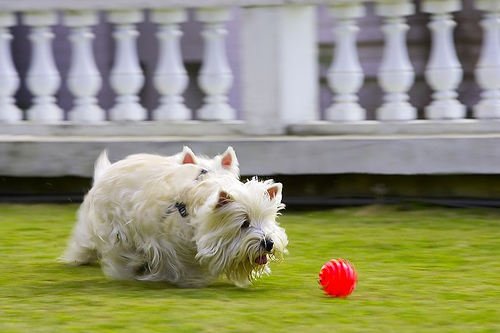

In [93]:
# Проверяем работу модели
clip_find_similar('Two small white dogs chasing a red ball', test_images_encoded, PATH_TEST_IMG)

### Выводы

Мы установили бейзлайн с помощью DummyRegressor, он равен RMSE 0.2810.

Создали и обучили MLP-нейросеть, удалось добиться значения метрики RMSE 0.23.

Загрузили и провели тестирование модели CLIP.

## Тестирование модели

### Введение

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

### Подготовка

#### Подготовка тестовых изображений

In [94]:
# Обработка изображений

# Кастомный датасет для загрузки изображений
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.img_names[idx]





# Итоговая функция для обработки изображений
def images_to_vectors(image_folder_path):

    # Проверка доступности GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Трансформации, которые будем использовать для предобработки изображений
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Загрузка предобученной модели ResNet50
    model_resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)
    model_resnet50 = torch.nn.Sequential(*list(model_resnet50.children())[:-1])
    
    model_resnet50 = model_resnet50.to(device)
    model_resnet50.eval();

    # Загружаем изображения
    dataset = ImageDataset(image_folder_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Вычисление векторных представлений
    image_vectors = {}
    with torch.no_grad():
        for images, img_names in tqdm(dataloader, desc="Processing Images"):
            images = images.to(device)
            vectors = model_resnet50(images)
            vectors = vectors.view(vectors.size(0), -1)
            vectors = vectors.cpu().numpy()
            for i, img_name in enumerate(img_names):
                image_vectors[img_name] = vectors[i]

    # Преобразуем словарь в датафрейм
    df_image_vectors = pd.Series(image_vectors).to_frame()
    df_image_vectors['image'] = df_image_vectors.index
    df_image_vectors = df_image_vectors.reset_index(drop=True)
    df_image_vectors = df_image_vectors.rename({0:'image_vector'}, axis=1)
    
    return df_image_vectors

In [95]:
# Создание датафрейма с векторами тестовых изображений
df_test_image_vectors = images_to_vectors(PATH_TEST_IMG)
df_test_image_vectors.head()

Processing Images: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


image_vector  \
0  [0.22392635, 0.027251812, 0.1470726, 2.4456618...   
1  [0.27040982, 0.01669491, 0.0, 2.6935344, 0.0, ...   
2  [0.04084114, 0.0, 0.1430845, 0.0, 0.0, 0.0, 0....   
3  [0.08849864, 0.0, 0.0011998158, 0.0, 0.0024893...   
4  [0.0, 0.0122283865, 0.05820716, 0.0, 0.0, 0.17...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1232148178_4f45cc3284.jpg  
2   123997871_6a9ca987b1.jpg  
3  1319634306_816f21677f.jpg  
4  1429546659_44cb09cbe2.jpg

#### Подготовка тестовых запросов

In [96]:
n_samples = 10
random_state = 758126

query_list_sample = df_test['query_text'].sample(n=n_samples, random_state=random_state).values

In [97]:
query_list_sample[0]

'A child in a fuzzy blue hat on a tricycle .'

#### Функция для тестирования модели

In [98]:
# Список слов и фраз для фильтрации
keywords = [
    'baby', 'child', 'toddler', 'kid', 'infant', 'newborn', 'boy', 'girl', 'teenager', 'teen',
    'juvenile', 'youngster', 'preschooler', 'schoolboy', 'schoolgirl', 'minor', 'playing', 'toy',
    'school', 'kindergarten', 'daycare', 'nursery', 'stroller', 'diaper', 'pacifier',
    'playground', 'cartoon', 'toy', 'doll', 'stuffed animal', 'crib', 'highchair', 'onesie',
    'parent', 'mom', 'dad', 'mother', 'father', 'nanny', 'babysitter', 'guardian'
]

# Функция для векторизации текстовых описаний
def vectorize_text(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', max_length=64, truncation=True, padding='max_length')
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

# Конкатенация векторов
def concatenate_vectors(row, text_vector):
    return np.concatenate([row['image_vector'], text_vector])

# Функция для предсказания на тестовых данных
def predict_model(model, test_loader, device):
    model.eval() 
    predictions = []

    with torch.no_grad(): 
        for X_test_torch in test_loader:
            X_test_torch = X_test_torch[0].to(device)
            y_pred = model(X_test_torch)
            predictions.append(y_pred.cpu().numpy())
    
    predictions = np.vstack(predictions)
    return predictions

# Функция для проверки наличия ключевых слов в описании
def contains_keywords(text):
    if any(keyword in text.lower() for keyword in keywords):
        display('This image is unavailable in your country in compliance with local laws.')
        return True




# Итоговая функция
def mlp_find_similar(text, dataframe, image_folder_path, model):
    # Проверка запроса по фильтру
    if contains_keywords(text):
        return
    
    # Определяем, можем ли мы проводить вычисления на GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Получение эмбеддинга текста
    text_emb = vectorize_text(text, tokenizer_bert, model_bert)

    # Создание комбинированного вектора
    dataframe['combined_vector'] = dataframe.apply(concatenate_vectors, axis=1, args=(text_emb,))

    # Переводим комбинированный вектор в признаки 
    df_vector = pd.DataFrame(dataframe['combined_vector'].values.tolist())
    df_vector['image'] = dataframe['image'].values

    # Подготовка тестовой выборки
    drop_columns = ['image']
    X_test = df_vector.drop(labels=drop_columns, axis=1)

    # Преобразование данных в тензор
    X_test_torch = torch.tensor(X_test.values, dtype=torch.float32)

    # Создание DataLoader для тестовой выборки
    test_dataset = TensorDataset(X_test_torch)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Получение предсказаний
    predictions = predict_model(model, test_loader, device)

    # Добавление предсказаний в датафрейм df_vector
    df_vector['prediction_score'] = predictions
    best_similarity = df_vector.loc[df_vector['prediction_score'].idxmax()]

    # Извлекаем имя изображения и оценку
    image_name = best_similarity['image']
    similarity_score = best_similarity['prediction_score']
    
    # Выводим на экран текст запроса, оценку, имя изображения и само изображение
    display(text)
    display(f'Similarity score: {similarity_score:.2f}')
    display(image_name)
    display(Image.open(os.path.join(image_folder_path, image_name)))

### Тестирование нейросети MLP

'This image is unavailable in your country in compliance with local laws.'

'many people walk through the store .'

'Similarity score: 0.67'

'2517284816_9b8fd3c6b6.jpg'

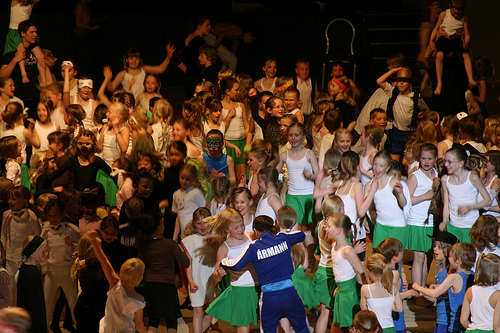

'A man is videotaping something .'

'Similarity score: 0.38'

'2517284816_9b8fd3c6b6.jpg'

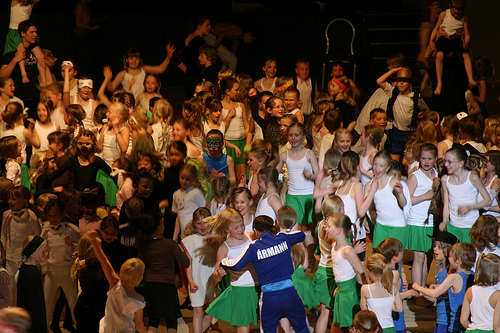

'Young man on a trick bicycle jumps at the top of a graffiti covered ramp .'

'Similarity score: 0.44'

'2517284816_9b8fd3c6b6.jpg'

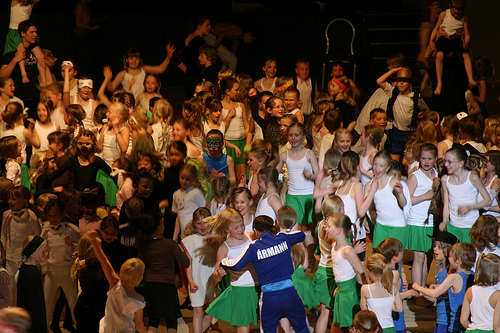

'Two Africans in red and blue shawls pose for a picture outside a barber shop .'

'Similarity score: 0.32'

'2517284816_9b8fd3c6b6.jpg'

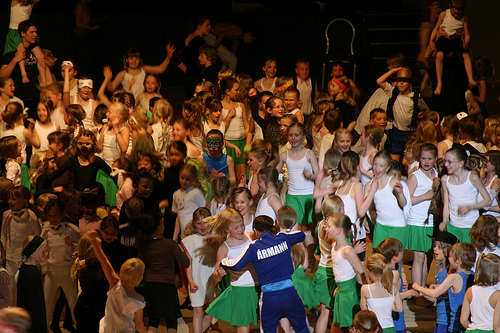

'This image is unavailable in your country in compliance with local laws.'

'This image is unavailable in your country in compliance with local laws.'

'This image is unavailable in your country in compliance with local laws.'

'This image is unavailable in your country in compliance with local laws.'

'Several dogs are running outside , with two vehicles in the background .'

'Similarity score: 0.32'

'1429546659_44cb09cbe2.jpg'

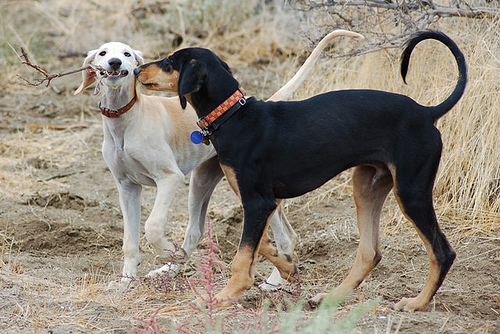

In [99]:
for text in query_list_sample:
    mlp_find_similar(text, df_test_image_vectors, PATH_TEST_IMG, model_mlp)

### Тестирование CLIP

'A child in a fuzzy blue hat on a tricycle .'

'Similarity score: 0.32'

'2428094795_d3a8f46046.jpg'

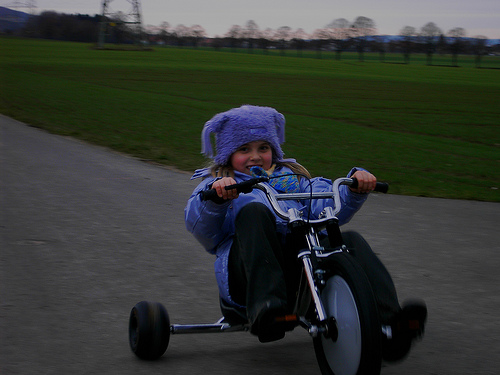

'many people walk through the store .'

'Similarity score: 0.28'

'440190907_bf8b7ba8ef.jpg'

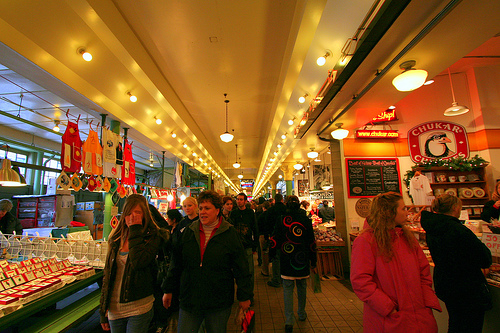

'A man is videotaping something .'

'Similarity score: 0.27'

'3089107423_81a24eaf18.jpg'

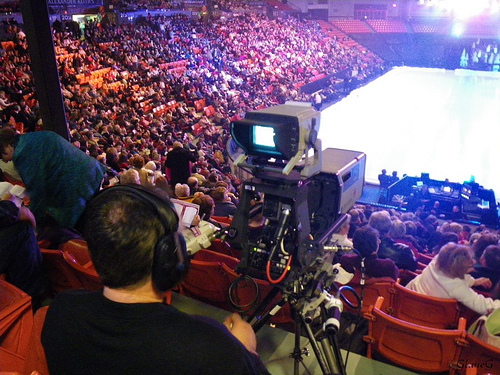

'Young man on a trick bicycle jumps at the top of a graffiti covered ramp .'

'Similarity score: 0.32'

'3459871361_92d1ecda36.jpg'

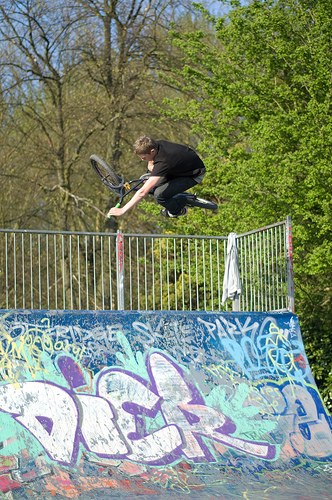

'Two Africans in red and blue shawls pose for a picture outside a barber shop .'

'Similarity score: 0.35'

'3330333217_1a69497a74.jpg'

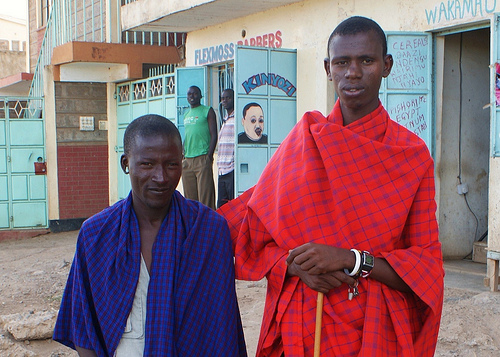

'Two black dogs are playing with an orange stuffed dog toy .'

'Similarity score: 0.35'

'3154152744_4e93ec8a62.jpg'

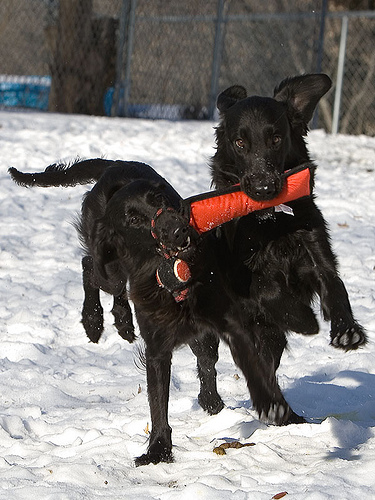

'Three teenagers drink Slurpees outside a convienience store .'

'Similarity score: 0.29'

'782401952_5bc5d3413a.jpg'

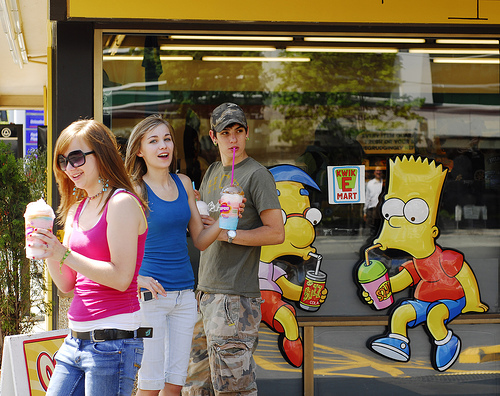

'A boy flying a red and white kite .'

'Similarity score: 0.34'

'2505056124_1276e8dbcb.jpg'

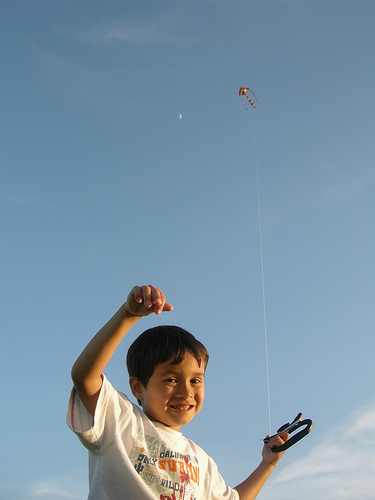

'Child in blue and grey shirt jumping off hill in the woods'

'Similarity score: 0.32'

'3393035454_2d2370ffd4.jpg'

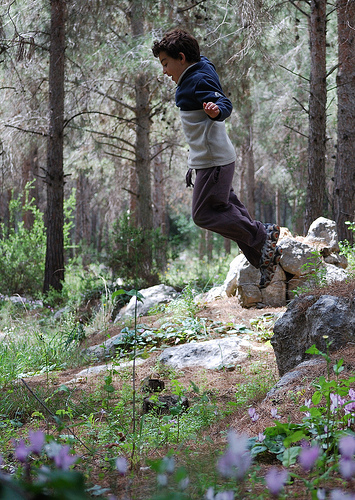

'Several dogs are running outside , with two vehicles in the background .'

'Similarity score: 0.32'

'3033612929_764d977bd5.jpg'

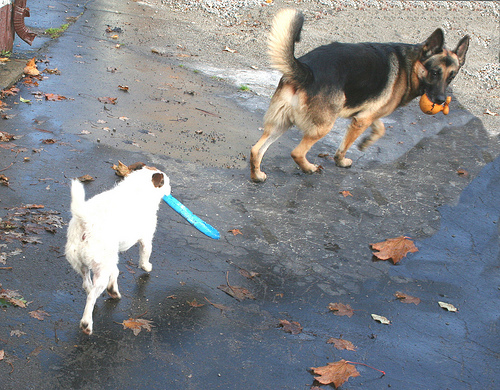

In [100]:
for text in query_list_sample:
    clip_find_similar(text, test_images_encoded, PATH_TEST_IMG)

## Выводы



Мы изучили данные, подготовили их и провели обучение модели нейронной сети. 
Полученная модель показывает себя немного лучше, чем DummyRegressor.
Так же мы провели тестирование модели CLIP от OpenAI. Данной модели не требуется обучение и она показала превосходные результаты.